# Homework 2

## Navigation
* [1. Import librarys and data](#section1)
* [2. Data cleaning and preprocess](#section2)
* [3. Model](#section3)
* [4. Experiments on decision tree](#section4)
  - [Default params](#section41)
  - [Change max depth](#section42)
  - [Change max features](#section43)
  - [Analysis changes](#section44)
* [5. Bagging and Boosting](#section5)
  - [Bagging](#section51)
  - [Boosting](#section52)
  - [Analysis different models](#section53)

<a id='section1'></a>
### Import librarys and data

In [1]:
import os
import pdb

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir
from os.path import join, exists

from sklearn import tree
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read data
data_path = "./smoke_detection_iot.csv"
df = pd.read_csv(data_path)

<a id='section2'></a>
### Data cleaning and preprocess

In [3]:
# Normalize
df = (df - np.min(df)) / (np.max(df) - np.min(df))

# Same cleaning step from Homework 1 since using the same dataset
df = df.drop(columns=["Unnamed: 0", "UTC", "CNT"])

X = df.copy().drop('Fire Alarm', axis=1).values
Y = df.copy()['Fire Alarm'].values
# train/test/val split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=9)
# X_val, X_test, Y_val, Y_test= train_test_split(X_train, Y_train, train_size=0.5)

<a id='section3'></a>
### Model

In [4]:
def build_decision_tree_clf(X_train, Y_train, train=True, max_depth=None, min_samples_split=2, max_features=None):
    clf = tree.DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        max_features=max_features,
    )
    if train:
        clf = clf.fit(X_train, Y_train)
    return clf

In [5]:
def predict(clf, X_test, use_prob=False):
    if use_prob:
        pred = clf.predict_prob(X_test)
    else:
        pred = clf.predict(X_test)
    return pred

In [6]:
def evaluate(clf, X_test, Y_test):
    return 

<a id='section4'></a>
### Experiments on decision tree

In [7]:
# Record experiment results
results = {
    'experiment': [],
    'accuracy': []
}


<a id='section41'></a>
#### Default params

In [8]:
# params
max_depth = None
max_features = None

# train and predict
decision_tree_clf = build_decision_tree_clf(X_train, Y_train, max_depth=max_depth, max_features=max_features)
Y_pred_train = predict(decision_tree_clf, X_train)
Y_pred_test = predict(decision_tree_clf, X_test)

# evaluate
accuracy_train = accuracy_score(Y_train, Y_pred_train)
f1_train = f1_score(Y_train, Y_pred_train)
accuracy_test = accuracy_score(Y_test, Y_pred_test)
f1_test = f1_score(Y_test, Y_pred_test)

# tree attributes
tree_attrs = decision_tree_clf.get_params()
tree_depth = decision_tree_clf.get_depth()
tree_max_features = decision_tree_clf.max_features_

print(f"Tree Attributes:")
for attr in tree_attrs:
    print(f"\t{attr}: {tree_attrs[attr]}")
print(f"\ttree depth: {tree_depth}")
print(f"\ttree max features: {tree_max_features}")
print(f"Accuracy(train): {accuracy_train}\nAccuracy(test): {accuracy_test}\nF1-score(train): {f1_train}\nF1-score(test): {f1_test}")

results['accuracy'].append(accuracy_test)
results['experiment'].append('max_depth=8, max_features=12')

Tree Attributes:
	ccp_alpha: 0.0
	class_weight: None
	criterion: gini
	max_depth: None
	max_features: None
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	random_state: None
	splitter: best
	tree depth: 8
	tree max features: 12
Accuracy(train): 1.0
Accuracy(test): 0.9998403321092129
F1-score(train): 1.0
F1-score(test): 0.9998881681950346


<a id='section42'></a>
#### Change max depth

In [9]:
# params
max_depth = 4
max_features = None

# train and predict
decision_tree_clf = build_decision_tree_clf(X_train, Y_train, max_depth=max_depth, max_features=max_features)
Y_pred_train = predict(decision_tree_clf, X_train)
Y_pred_test = predict(decision_tree_clf, X_test)

# evaluate
accuracy_train = accuracy_score(Y_train, Y_pred_train)
f1_train = f1_score(Y_train, Y_pred_train)
accuracy_test = accuracy_score(Y_test, Y_pred_test)
f1_test = f1_score(Y_test, Y_pred_test)

# tree attributes
tree_attrs = decision_tree_clf.get_params()
tree_depth = decision_tree_clf.get_depth()
tree_max_features = decision_tree_clf.max_features_

print(f"Tree Attributes:")
for attr in tree_attrs:
    print(f"\t{attr}: {tree_attrs[attr]}")
print(f"\ttree depth: {tree_depth}")
print(f"\ttree max features: {tree_max_features}")
print(f"Accuracy(train): {accuracy_train}\nAccuracy(test): {accuracy_test}\nF1-score(train): {f1_train}\nF1-score(test): {f1_test}")

results['accuracy'].append(accuracy_test)
results['experiment'].append('max_depth=4, max_features=12')

Tree Attributes:
	ccp_alpha: 0.0
	class_weight: None
	criterion: gini
	max_depth: 4
	max_features: None
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	random_state: None
	splitter: best
	tree depth: 4
	tree max features: 12
Accuracy(train): 0.9886436212677631
Accuracy(test): 0.9876257384639949
F1-score(train): 0.9921190044183437
F1-score(test): 0.9914056002217909


In [10]:
# params
max_depth = 2
max_features = None

# train and predict
decision_tree_clf = build_decision_tree_clf(X_train, Y_train, max_depth=max_depth, max_features=max_features)
Y_pred_train = predict(decision_tree_clf, X_train)
Y_pred_test = predict(decision_tree_clf, X_test)

# evaluate
accuracy_train = accuracy_score(Y_train, Y_pred_train)
f1_train = f1_score(Y_train, Y_pred_train)
accuracy_test = accuracy_score(Y_test, Y_pred_test)
f1_test = f1_score(Y_test, Y_pred_test)

# tree attributes
tree_attrs = decision_tree_clf.get_params()
tree_depth = decision_tree_clf.get_depth()
tree_max_features = decision_tree_clf.max_features_

print(f"Tree Attributes:")
for attr in tree_attrs:
    print(f"\t{attr}: {tree_attrs[attr]}")
print(f"\ttree depth: {tree_depth}")
print(f"\ttree max features: {tree_max_features}")
print(f"Accuracy(train): {accuracy_train}\nAccuracy(test): {accuracy_test}\nF1-score(train): {f1_train}\nF1-score(test): {f1_test}")

results['accuracy'].append(accuracy_test)
results['experiment'].append('max_depth=2, max_features=12')

Tree Attributes:
	ccp_alpha: 0.0
	class_weight: None
	criterion: gini
	max_depth: 2
	max_features: None
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	random_state: None
	splitter: best
	tree depth: 2
	tree max features: 12
Accuracy(train): 0.9332987386236627
Accuracy(test): 0.9304646335621907
F1-score(train): 0.952194312525033
F1-score(test): 0.9500086093095335


<a id='section43'></a>
#### Change max features

In [11]:
# params
max_depth = None
max_features = 2

# train and predict
decision_tree_clf = build_decision_tree_clf(X_train, Y_train, max_depth=max_depth, max_features=max_features)
Y_pred_train = predict(decision_tree_clf, X_train)
Y_pred_test = predict(decision_tree_clf, X_test)

# evaluate
accuracy_train = accuracy_score(Y_train, Y_pred_train)
f1_train = f1_score(Y_train, Y_pred_train)
accuracy_test = accuracy_score(Y_test, Y_pred_test)
f1_test = f1_score(Y_test, Y_pred_test)

# tree attributes
tree_attrs = decision_tree_clf.get_params()
tree_depth = decision_tree_clf.get_depth()
tree_max_features = decision_tree_clf.max_features_

print(f"Tree Attributes:")
for attr in tree_attrs:
    print(f"\t{attr}: {tree_attrs[attr]}")
print(f"\ttree depth: {tree_depth}")
print(f"\ttree max features: {tree_max_features}")
print(f"Accuracy(train): {accuracy_train}\nAccuracy(test): {accuracy_test}\nF1-score(train): {f1_train}\nF1-score(test): {f1_test}")

results['accuracy'].append(accuracy_test)
results['experiment'].append('max_depth=8, max_features=2')

Tree Attributes:
	ccp_alpha: 0.0
	class_weight: None
	criterion: gini
	max_depth: None
	max_features: 2
	max_leaf_nodes: None
	min_impurity_decrease: 0.0
	min_samples_leaf: 1
	min_samples_split: 2
	min_weight_fraction_leaf: 0.0
	random_state: None
	splitter: best
	tree depth: 19
	tree max features: 2
Accuracy(train): 1.0
Accuracy(test): 0.9994411623822449
F1-score(train): 1.0
F1-score(test): 0.9996086980826207


<a id='section44'></a>
#### Analysis changes

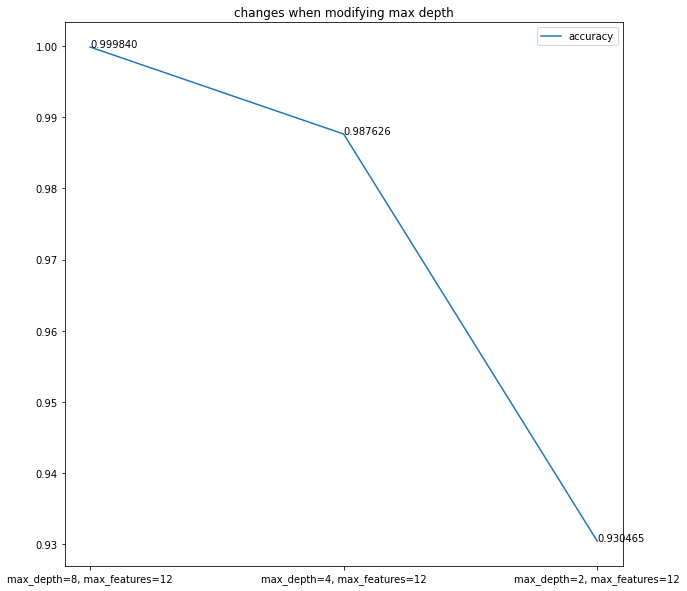

In [12]:
results_df = pd.DataFrame(results, columns=['experiment', 'accuracy'])
x = [1, 2, 3]
y = results_df[:3].values[:, 1]
labels = results_df[:3].values[:, 0]
plt.figure(figsize=(10, 10))
plt.plot(x, y)
plt.xticks(x, labels)
plt.title("changes when modifying max depth")
plt.legend(['accuracy'])
for i, j in enumerate(y):
    plt.text(i+1, j, f"{j:.6f}")
plt.show()

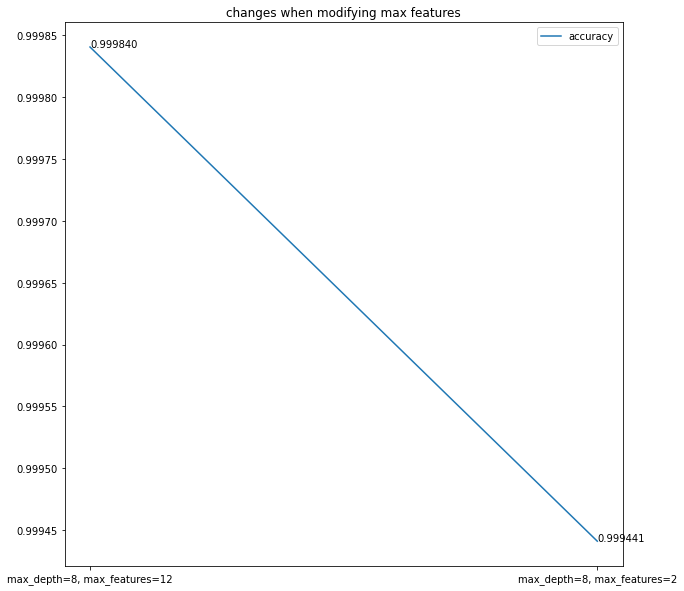

In [13]:
results_df = pd.DataFrame(results, columns=['experiment', 'accuracy'])
x = [1, 2]
y = [results_df.values[0, 1]] + [results_df.values[3, 1]]
labels = [results_df.values[0, 0]] + [results_df.values[3, 0]]
plt.figure(figsize=(10, 10))
plt.plot(x, y)
plt.title("changes when modifying max features")
plt.xticks(x, labels)
plt.legend(['accuracy'])
for i, j in enumerate(y):
    plt.text(i+1, j, f"{j:.6f}")
plt.show()

<a id='section5'></a>
### Bagging and Boosting

In [14]:
def build_cv(n_splits=10, n_repeats=5, random_state=8):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    return cv

In [15]:
def evaluate(clf, X, Y, cv, scoring='accuracy', n_jobs=-1, error_score='raise'):
    n_scores = cross_val_score(clf, X, Y, scoring=scoring, cv=cv, n_jobs=n_jobs, error_score=error_score)
    mean_accuracy = np.mean(n_scores)
    std_accuracy = np.std(n_scores)
    return mean_accuracy, std_accuracy

<a id='section51'></a>
#### Bagging

In [16]:
def build_bagging_clf(n_estimator=50):
    clf = BaggingClassifier(n_estimators=n_estimator)
    return clf

In [17]:
bagging_clf = build_bagging_clf()
cv = build_cv()
mean_accuracy, std_accuracy = evaluate(bagging_clf, X, Y, cv)
print(f"Accuracy: {mean_accuracy} ({std_accuracy})")

results['accuracy'].append(mean_accuracy)
results['experiment'].append('bagging')


Accuracy: 0.9999073926233435 (0.0001466512853674599)


<a id='section52'></a>
#### Boosting

In [18]:
def build_boosting_clf(X, Y, algorithm='SAMME', n_estimator=4, train=True):
    clf = AdaBoostClassifier(n_estimators=n_estimator, algorithm=algorithm)
    # if train:
    #     clf = clf.fit(X, Y)
    return clf

In [19]:
boosting_clf = build_boosting_clf(X, Y)
cv = build_cv()
mean_accuracy, std_accuracy = evaluate(boosting_clf, X, Y, cv)
print(f"Accuracy: {mean_accuracy} ({std_accuracy})")

results['accuracy'].append(mean_accuracy)
results['experiment'].append('boosting')

Accuracy: 0.927462877215392 (0.004853930141024964)


<a id='section53'></a>
#### Analysis different models

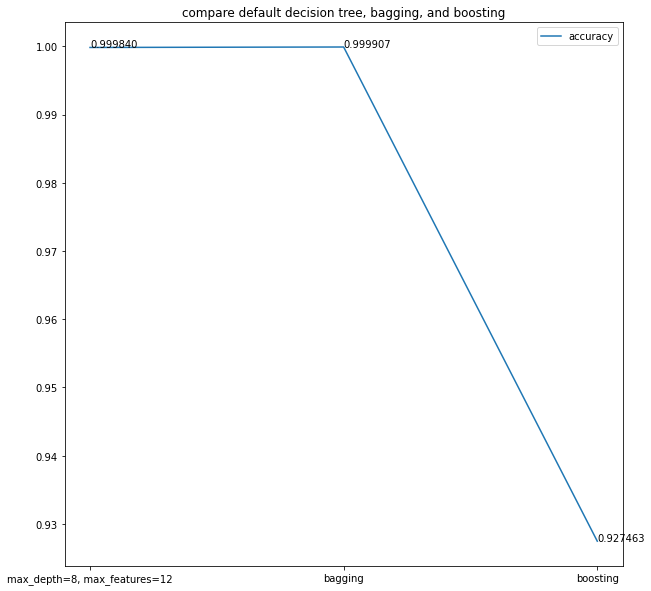

In [20]:
results_df = pd.DataFrame(results, columns=['experiment', 'accuracy'])
x = [1, 2, 3]
y = [results_df.values[0, 1]] + [results_df.values[4, 1]] + [results_df.values[5, 1]]
labels = [results_df.values[0, 0]] + [results_df.values[4, 0]] + [results_df.values[5, 0]]
plt.figure(figsize=(10, 10))
plt.plot(x, y)
plt.xticks(x, labels)
plt.title("compare default decision tree, bagging, and boosting")
plt.legend(['accuracy'])
for i, j in enumerate(y):
    plt.text(i+1, j, f"{j:.6f}")
plt.show()